# Мониторинг безопасности одиноких пожилых людей

In [33]:
from pathlib import Path
import pickle
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузим данные


Будем исследовать и использовать данные от датчиков газа и температуры, так как именно эти показатели могут указать на аномалии.

In [3]:
DATA_PATH = "/content/drive/MyDrive/elderly_people_safety/data"

In [4]:
data = pd.read_csv(Path(DATA_PATH, "database_gas.csv"))
data["timestamp"] = pd.to_datetime(data["timestamp"]).round('1s').dt.tz_localize(None)
data

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2019-11-06 11:37:13,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0
1,2019-11-06 11:37:33,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0
2,2019-11-06 11:37:53,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0
3,2019-11-06 11:38:13,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0
4,2019-11-06 11:38:33,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0
...,...,...,...,...,...,...,...,...,...,...
416148,2020-02-13 11:56:54,20.62,57.75,62.0,518.0,524.0,698.0,642.0,591.0,157.0
416149,2020-02-13 11:57:14,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0
416150,2020-02-13 11:57:34,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0
416151,2020-02-13 11:57:54,20.62,57.74,63.0,518.0,524.0,698.0,641.0,591.0,157.0


Поскольку 20 секунд - это очень короткий интервал, в таблице слишком много данных, с которыми не удобно работать.

**Cделаем агрегацию - средний показатель за 10 мин.**

In [5]:
data = data.groupby(pd.Grouper(key="timestamp", freq="10min")).agg("mean").reset_index()
data

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2019-11-06 11:30:00,19.632222,53.832222,127.666667,567.444444,479.666667,732.222222,649.555556,565.111111,124.000000
1,2019-11-06 11:40:00,19.639667,53.970000,128.600000,579.800000,496.366667,731.500000,649.533333,565.433333,114.700000
2,2019-11-06 11:50:00,19.993333,49.446000,102.300000,600.033333,528.766667,760.166667,700.600000,611.666667,106.533333
3,2019-11-06 12:00:00,19.963333,47.408333,80.500000,615.033333,557.733333,781.266667,737.133333,656.900000,100.266667
4,2019-11-06 12:10:00,19.417667,48.102333,77.033333,619.633333,567.366667,787.433333,749.600000,676.933333,95.866667
...,...,...,...,...,...,...,...,...,...,...
14254,2020-02-13 11:10:00,20.654000,57.908667,43.033333,518.166667,525.833333,700.500000,643.800000,594.633333,156.633333
14255,2020-02-13 11:20:00,20.598333,58.131667,42.533333,518.000000,527.500000,701.133333,643.866667,594.300000,155.733333
14256,2020-02-13 11:30:00,20.590333,58.085667,42.833333,517.966667,526.100000,699.933333,642.800000,592.466667,155.600000
14257,2020-02-13 11:40:00,20.590000,57.969000,46.100000,517.633333,524.733333,699.000000,642.000000,591.533333,156.133333


In [6]:
measurements = ["temperature", "humidity", "CO2CosIRValue", "CO2MG811Value", "MOX1", "MOX2", "MOX3", "MOX4", "COValue"]

# EDA

In [7]:
ANOMALY_TIME_START = "2020-01-25"

In [8]:
fig = px.line(data, x="timestamp", y=measurements)
fig.add_vline(ANOMALY_TIME_START, line_width=3, line_dash="dash", line_color="black")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Согласно описанию кейса после 2020-01-25 начинается период, когда никого не было в помещении, и эти данные используются как эталонные (те, которые отличаются от нормальных, когда человек присутствует в квартире). И график это подтверждает: видно, что после 2020-01-25 поведение датчиков сильно изменяется.

Кроме того, в типичном периоде видны паттерны в течении дня, которые так же можно исследовать.

Во временных рядах можно было бы усмотреть определенную тенденцию, но в силу того, что таргет отделен строго по времени будем рассматривать просто каждый час как отдельное наблюдение. Кроме того, наблюдения нужно будет обязательно перемешать.

In [9]:
data["anomaly"] = (data["timestamp"] >= ANOMALY_TIME_START).astype(int)
data

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,anomaly
0,2019-11-06 11:30:00,19.632222,53.832222,127.666667,567.444444,479.666667,732.222222,649.555556,565.111111,124.000000,0
1,2019-11-06 11:40:00,19.639667,53.970000,128.600000,579.800000,496.366667,731.500000,649.533333,565.433333,114.700000,0
2,2019-11-06 11:50:00,19.993333,49.446000,102.300000,600.033333,528.766667,760.166667,700.600000,611.666667,106.533333,0
3,2019-11-06 12:00:00,19.963333,47.408333,80.500000,615.033333,557.733333,781.266667,737.133333,656.900000,100.266667,0
4,2019-11-06 12:10:00,19.417667,48.102333,77.033333,619.633333,567.366667,787.433333,749.600000,676.933333,95.866667,0
...,...,...,...,...,...,...,...,...,...,...,...
14254,2020-02-13 11:10:00,20.654000,57.908667,43.033333,518.166667,525.833333,700.500000,643.800000,594.633333,156.633333,1
14255,2020-02-13 11:20:00,20.598333,58.131667,42.533333,518.000000,527.500000,701.133333,643.866667,594.300000,155.733333,1
14256,2020-02-13 11:30:00,20.590333,58.085667,42.833333,517.966667,526.100000,699.933333,642.800000,592.466667,155.600000,1
14257,2020-02-13 11:40:00,20.590000,57.969000,46.100000,517.633333,524.733333,699.000000,642.000000,591.533333,156.133333,1


### Посмотрим на распределение признаков в зависимости от периода (аномалия/нет)

Типичным периодом будем считать период, когда в квартире кто-то бы, и нетипичным – когда никого не было.

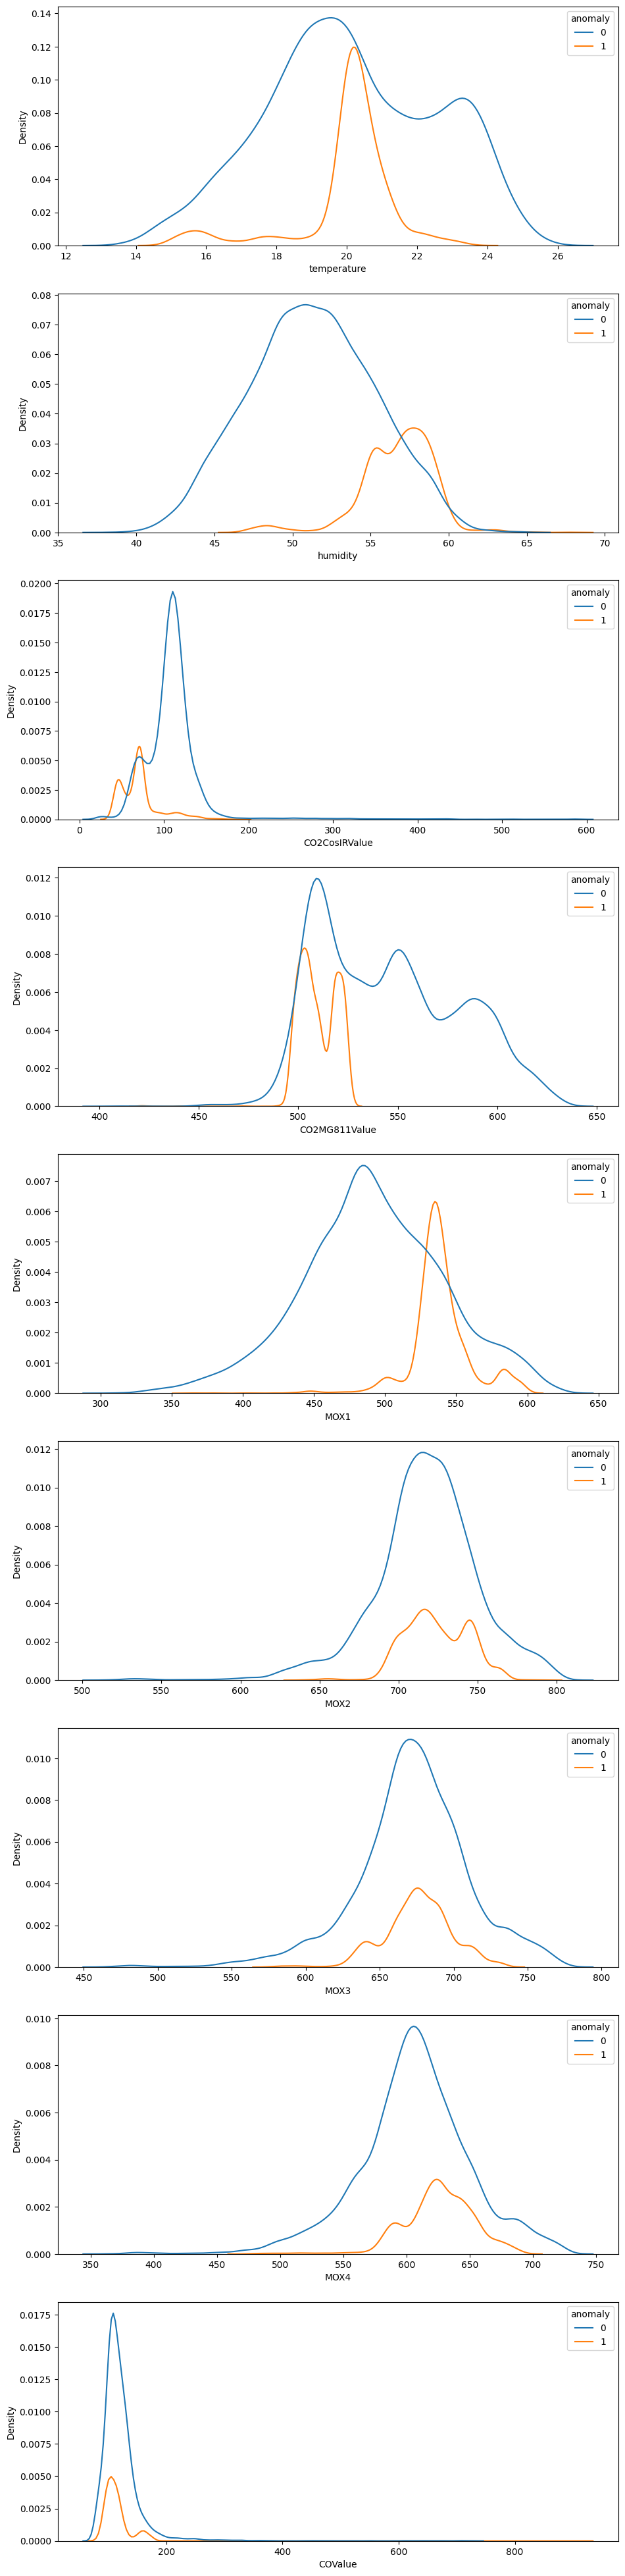

In [10]:
fig, ax = plt.subplots(len(measurements), 1, figsize=(11, 50))

for i, feature in enumerate(measurements):
    sns.kdeplot(ax=ax[i], data=data, x=feature, hue=data.anomaly)

Заметно, что распределения действительно в целом отличаются для типичного и нетипичного периода.

### Посмотрим на распределение каждого признака по часам

In [11]:
data['hour'] = data.timestamp.dt.hour

#### Распределение в типичный период

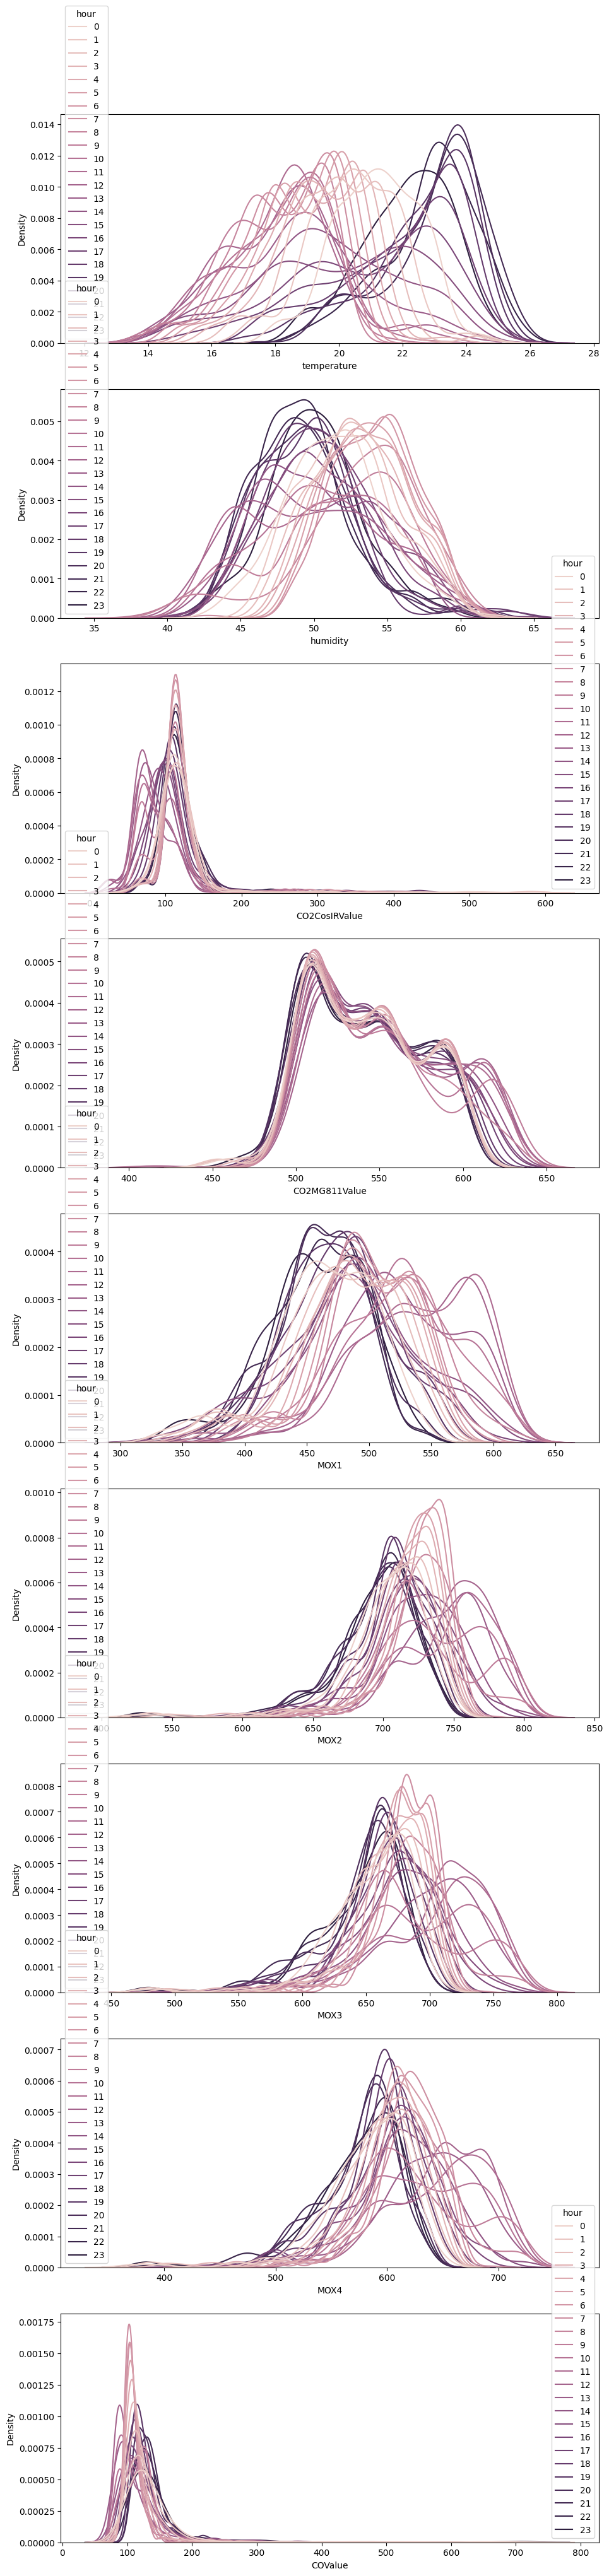

In [12]:
fig, ax = plt.subplots(len(measurements), 1, figsize=(11, 50))

for i, feature in enumerate(measurements):
    sns.kdeplot(ax=ax[i], data=data[data['anomaly']==0], x=feature, hue=data['hour'])

#### Распределение в нетипичный период

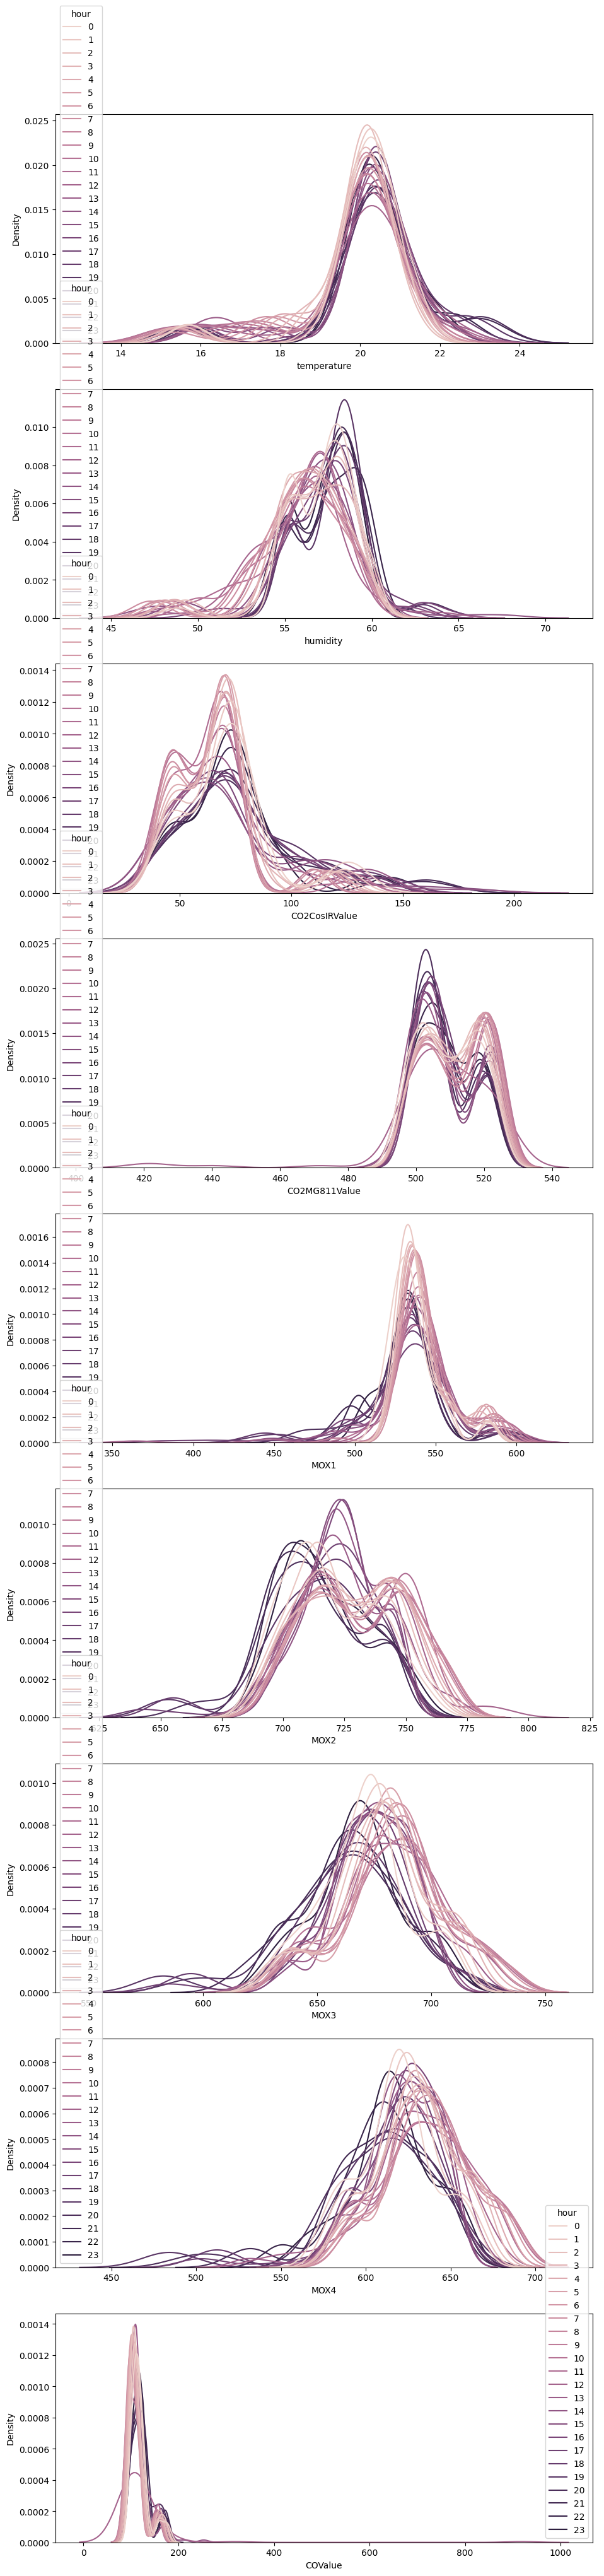

In [13]:
fig, ax = plt.subplots(len(measurements), 1, figsize=(11, 50))

for i, feature in enumerate(measurements):
    sns.kdeplot(ax=ax[i], data=data[data['anomaly']==1], x=feature, hue=data['hour'])

Можно заметить, что распределения отличаются от часа к часу как в типичном, так и в нетипичном периоде. Поэтому для каждого наблюдения укажем час, в который происходит наблюдение, тк это может быть полезным доп признаком.

### Попробуем "на глаз" проверить отделимы ли аномальные часы от типичных

Укрупним группировку данных до часа, чтобы затем на этом же датасете учится предсказывать аномален ли час

In [14]:
data_hour_agg = data.groupby(pd.Grouper(key="timestamp", freq="1H")).agg("mean")
data_hour_agg

,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,anomaly,hour
timestamp,,,,,,,,,,,
2019-11-06 11:00:00,19.755074,52.416074,119.522222,582.425926,501.600000,741.296296,666.562963,580.737037,115.077778,0.0,11.0
2019-11-06 12:00:00,19.533222,49.122222,80.866667,617.844444,555.238889,776.822222,731.605556,653.811111,94.527778,0.0,12.0
2019-11-06 13:00:00,19.699111,51.239833,84.727778,616.772222,530.872222,760.505556,705.661111,622.116667,95.533333,0.0,13.0
2019-11-06 14:00:00,20.202778,49.903167,81.994444,618.461111,427.705556,757.966667,707.561111,625.294444,111.450000,0.0,14.0
2019-11-06 15:00:00,20.311944,50.692444,85.977778,615.988889,385.505556,753.555556,702.250000,621.472222,107.855556,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-13 07:00:00,20.275222,58.441167,43.233333,518.155556,528.961111,703.366667,646.855556,599.111111,148.238889,1.0,7.0
2020-02-13 08:00:00,20.341500,58.252778,42.883333,518.011111,530.033333,704.350000,647.744444,600.761111,149.438889,1.0,8.0
2020-02-13 09:00:00,20.396167,57.806222,42.988889,518.072222,530.455556,705.305556,649.083333,601.194444,148.750000,1.0,9.0


In [15]:
sns.pairplot(data_hour_agg, hue="anomaly", plot_kws={"alpha": 0.1});

Output hidden; open in https://colab.research.google.com to view.

На графиках видно, что в целом по многим признакам классы (аномалия/нет) действительно могут быть разделимы.

### Проверим признаки на мультиколлинеарность

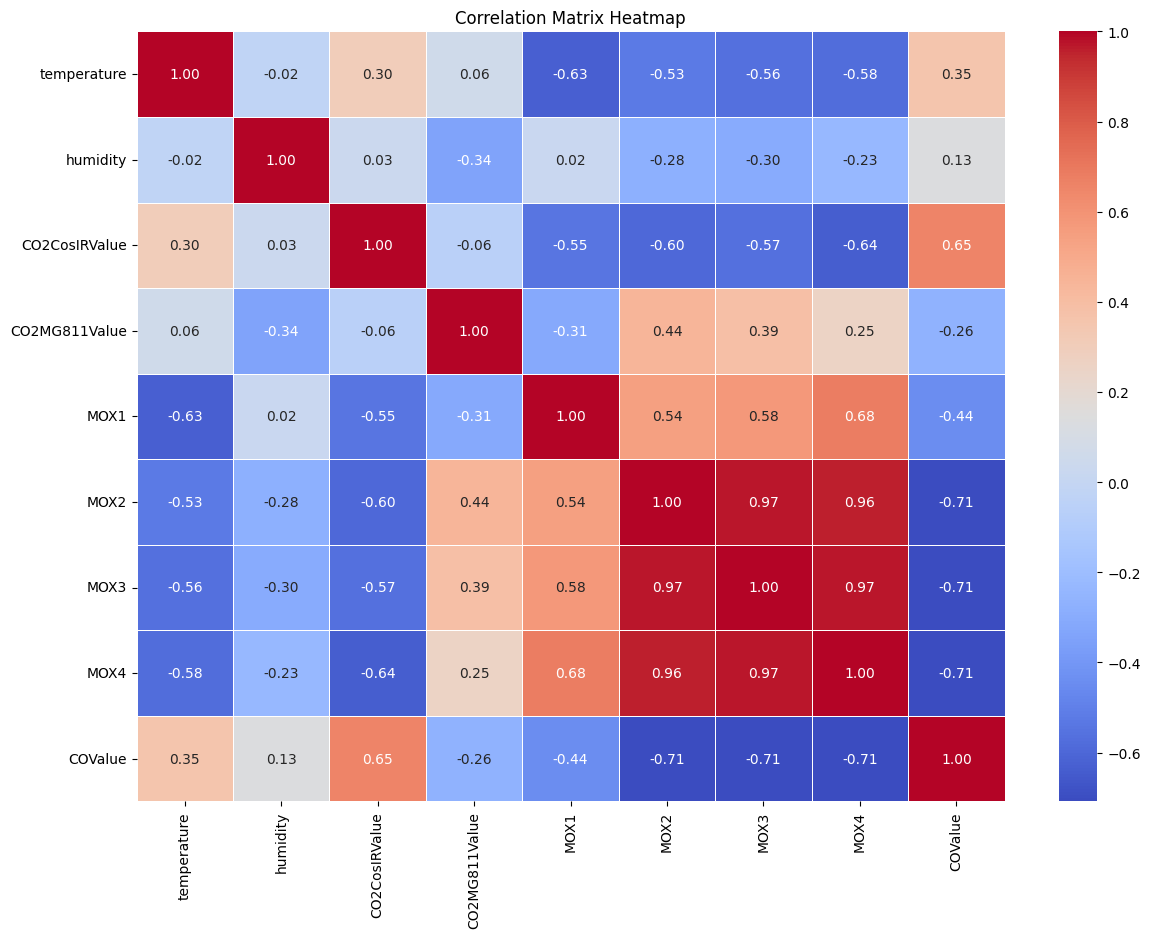

In [16]:
correlation_matrix = data_hour_agg[measurements].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')

plt.show()

Можно увидеть, что сильная корреляция присуствует у 3 факторов: MOX2, MOX3, MOX4.
Соответственно, мы можем исключить признаки MOX3, MOX4.

In [17]:
data_hour_agg.drop(['MOX3', 'MOX4'], axis=1, inplace=True)

In [18]:
data_hour_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2377 entries, 2019-11-06 11:00:00 to 2020-02-13 11:00:00
Freq: H
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    2319 non-null   float64
 1   humidity       2319 non-null   float64
 2   CO2CosIRValue  2319 non-null   float64
 3   CO2MG811Value  2319 non-null   float64
 4   MOX1           2319 non-null   float64
 5   MOX2           2319 non-null   float64
 6   COValue        2319 non-null   float64
 7   anomaly        2377 non-null   float64
 8   hour           2377 non-null   float64
dtypes: float64(9)
memory usage: 185.7 KB


# Эксперименты с моделями

In [19]:
data_hour_agg["anomaly"] = data_hour_agg["anomaly"].astype(int)
data_hour_agg["hour"] = data_hour_agg.index.hour
data_hour_agg = data_hour_agg.dropna()
data_hour_agg

,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,COValue,anomaly,hour
timestamp,,,,,,,,,
2019-11-06 11:00:00,19.755074,52.416074,119.522222,582.425926,501.600000,741.296296,115.077778,0,11
2019-11-06 12:00:00,19.533222,49.122222,80.866667,617.844444,555.238889,776.822222,94.527778,0,12
2019-11-06 13:00:00,19.699111,51.239833,84.727778,616.772222,530.872222,760.505556,95.533333,0,13
2019-11-06 14:00:00,20.202778,49.903167,81.994444,618.461111,427.705556,757.966667,111.450000,0,14
2019-11-06 15:00:00,20.311944,50.692444,85.977778,615.988889,385.505556,753.555556,107.855556,0,15
...,...,...,...,...,...,...,...,...,...
2020-02-13 07:00:00,20.275222,58.441167,43.233333,518.155556,528.961111,703.366667,148.238889,1,7
2020-02-13 08:00:00,20.341500,58.252778,42.883333,518.011111,530.033333,704.350000,149.438889,1,8
2020-02-13 09:00:00,20.396167,57.806222,42.988889,518.072222,530.455556,705.305556,148.750000,1,9


In [20]:
# Выборка не сбалансированная
data_hour_agg["anomaly"].value_counts()

0    1896
1     423
Name: anomaly, dtype: int64

In [21]:
features = data_hour_agg.drop("anomaly", axis=1)
target = data_hour_agg["anomaly"]

In [22]:
print(features.shape)
print(target.shape)

(2319, 8)
(2319,)


In [23]:
HOUR = ['hour']
NUMERIC = features.columns.to_list()
NUMERIC.remove('hour')
NUMERIC

['temperature',
 'humidity',
 'CO2CosIRValue',
 'CO2MG811Value',
 'MOX1',
 'MOX2',
 'COValue']

### LogisticRegression

In [24]:
# кодировка категориальных признаков и маштабирование численных
features_log_reg = features.copy()

col_transformer_log_reg = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        HOUR
    ),
    (
        StandardScaler(),
        NUMERIC
    ),
    remainder='passthrough')

In [25]:
%%time

model_log_reg = LogisticRegression(class_weight='balanced', random_state=42)

pipeline_log_reg = make_pipeline(col_transformer_log_reg, model_log_reg)

params_grid_log_reg = {'logisticregression__C': [0.001,0.01,0.1,1,10,100,1000]}
grid_log_reg = GridSearchCV(
    pipeline_log_reg,
    param_grid=params_grid_log_reg,
    scoring='f1',
    n_jobs=-1,
    verbose=1)

grid_log_reg.fit(features_log_reg, target)

best_model_log_reg = grid_log_reg.best_estimator_
best_parametrs_log_reg = grid_log_reg.best_params_
best_result_log_reg = grid_log_reg.best_score_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: user 228 ms, sys: 98.8 ms, total: 327 ms
Wall time: 3.06 s


In [26]:
print(best_result_log_reg) # лучший результат модели
print(best_parametrs_log_reg) # лучшие параметры модели

0.8365557097924349
{'logisticregression__C': 0.1}


### RandomForest

In [27]:
# кодировка категориальных признаков и маштабирование численных
features_forest = features.copy()

col_transformer_forest = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        HOUR
    ),
    (
        StandardScaler(),
        NUMERIC
    ),
    remainder='passthrough')

In [28]:
%%time

model_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

pipeline_forest = make_pipeline(col_transformer_forest, model_forest)

params_grid_forest = {'randomforestclassifier__n_estimators': range(100, 250, 50),
                      'randomforestclassifier__max_depth': range(2, 15)}

grid_forest = GridSearchCV(
    pipeline_forest,
    param_grid=params_grid_forest,
    scoring='f1',
    n_jobs=-1,
    verbose=1)

grid_forest.fit(features_forest, target)

best_model_forest = grid_forest.best_estimator_
best_parametrs_forest = grid_forest.best_params_
best_result_forest = grid_forest.best_score_

Fitting 5 folds for each of 39 candidates, totalling 195 fits
CPU times: user 1.87 s, sys: 191 ms, total: 2.06 s
Wall time: 1min 24s


In [29]:
print(best_result_forest) # лучший результат модели
print(best_parametrs_forest) # лучшие параметры модели

0.8291700718432459
{'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 100}


### LGBMClassifier

In [30]:
# кодируем категориальные признаки
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_lgb = features.copy()
features_lgb[HOUR] = ord_enc.fit_transform(features_lgb[HOUR]).astype(int)

In [34]:
%%time

model_lgb = LGBMClassifier(class_weight='balanced', random_state=42)

params_grid_lgb = {'n_estimators': range(100, 250, 50),
                   'max_depth': range(2, 15),
                   'num_leaves': range(15, 25)}

fit_params = {'categorical_feature': HOUR}

grid_lgb = RandomizedSearchCV(
    model_lgb,
    param_distributions=params_grid_lgb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1)

grid_lgb.fit(features_lgb, target, **fit_params)

best_model_lgb = grid_lgb.best_estimator_
best_parametrs_lgb = grid_lgb.best_params_
best_result_lgb = grid_lgb.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 423, number of negative: 1896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 2319, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 341 ms, sys: 66.3 ms, total: 407 ms
Wall time: 6.83 s


In [35]:
print(best_result_lgb) # лучший результат модели
print(best_parametrs_lgb) # лучшие параметры модели

0.7963683927642146
{'num_leaves': 24, 'n_estimators': 100, 'max_depth': 2}


## Сохраняем модели для сервиса

In [36]:
MODEL_PATH = "/content/drive/MyDrive/elderly_people_safety/models"

In [39]:
pickle.dump(best_model_log_reg, open(f"{MODEL_PATH}/log_reg_model.pkl", "wb"))
pickle.dump(best_model_forest, open(f"{MODEL_PATH}/forest_model.pkl", "wb"))
pickle.dump(best_model_lgb, open(f"{MODEL_PATH}/lgb_model.pkl", "wb"))